# Skincancer HAM-dataset using Pytorch

### 1. Standardimporter

In [135]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import os
from PIL import Image
from skimage import io, transform

import numpy as np
import pandas as pd
#from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
homePath = os.path.dirname("/home/johan/Dropbox/coding/")
# print(homePath) ---> /home/johan/Dropbox/coding

basePath = homePath + "/" +"ml/Datasets/skin-cancer-mnist-ham10000/images_in_one"
# print(basePath) ---> /home/johan/Dropbox/coding/ml/Datasets/skin-cancer-mnist-ham10000/

imageFolder = "images_per_label_splitted_sets"

metadataSkincancerFilename =  "../../../ml/Datasets/skin-cancer-mnist-ham10000/csv/HAM10000_metadata.csv"

In [4]:
print(metadataSkincancerFilename)

../../../ml/Datasets/skin-cancer-mnist-ham10000/csv/HAM10000_metadata.csv


In [5]:
# Importera metadatan i en Pandas DataFrame:

skincancer_df = pd.read_csv(metadataSkincancerFilename)

In [6]:
# Kolla om vi har några noll-värden i vår Dataframe:

skincancer_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [7]:
# Enligt ovan är det bara i "age"-kolumnen som vi har noll-värden. 
# Dessa fyller vi ut genom att beräkna medevärdet:

skincancer_df['age'].fillna((skincancer_df['age'].mean()), inplace=True)

In [8]:
labels = skincancer_df['dx']
num_classes = len(labels.unique()) # --> 7

In [9]:
np_labels = np.array(labels)

In [10]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

enc_labels = label_encoder.fit_transform(np_labels)
enc_labels

array([2, 2, 2, ..., 0, 0, 4])

In [11]:
torch_labels = torch.from_numpy(enc_labels)
torch_labels

tensor([2, 2, 2,  ..., 0, 0, 4])

In [12]:
# Innan vi fortsätter måste vi göra om 
# text-datan till numeriska features.

# 1. Flytta labels sist i df
# 2. Flytta age till efter image_id
# 3. Alla categorical features emellan.

skincancer_df = skincancer_df[['lesion_id', 'image_id', 'age', 'dx_type', 'sex', 'localization', 'dx']]
skincancer_df.head(n = 3)

,lesion_id,image_id,age,dx_type,sex,localization,dx
0,HAM_0000118,ISIC_0027419,80.0,histo,male,scalp,bkl
1,HAM_0000118,ISIC_0025030,80.0,histo,male,scalp,bkl
2,HAM_0002730,ISIC_0026769,80.0,histo,male,scalp,bkl


In [13]:
from sklearn.preprocessing import LabelEncoder

In [14]:
dxtype_feat_df = skincancer_df.iloc[:, 3]
dxtype_feat_df.value_counts()

histo        5340
follow_up    3704
consensus     902
confocal       69
Name: dx_type, dtype: int64

In [15]:
sex_feat_df = skincancer_df.iloc[:, 4]
sex_feat_df.value_counts()

male       5406
female     4552
unknown      57
Name: sex, dtype: int64

In [16]:
loc_feat_df = skincancer_df.iloc[:, 3]
loc_feat_df.value_counts()

histo        5340
follow_up    3704
consensus     902
confocal       69
Name: dx_type, dtype: int64

In [17]:
label_df = skincancer_df.iloc[:, 6]
label_df.value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

(array([  69.,    0.,    0.,  902.,    0.,    0., 3704.,    0.,    0.,
        5340.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

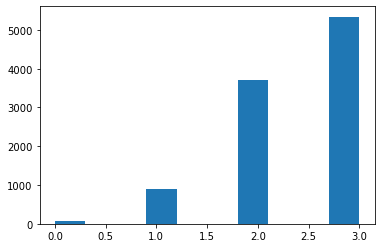

In [18]:
le = LabelEncoder()
dxtype_feat = le.fit_transform(dxtype_feat_df)
plt.hist(dxtype_feat)

(array([  69.,    0.,    0.,  902.,    0.,    0., 3704.,    0.,    0.,
        5340.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

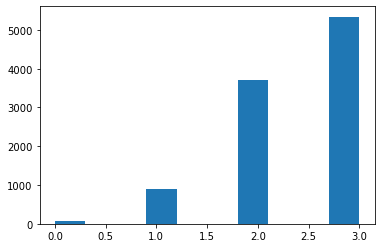

In [19]:
le = LabelEncoder()
loc_feat = le.fit_transform(loc_feat_df)
plt.hist(loc_feat)

(array([4552.,    0.,    0.,    0.,    0., 5406.,    0.,    0.,    0.,
          57.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

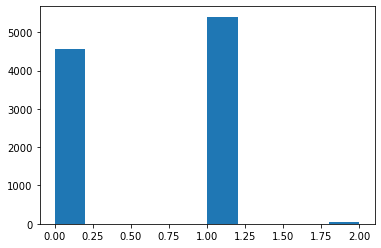

In [20]:
le = LabelEncoder()
sex_feat = le.fit_transform(sex_feat_df)
plt.hist(sex_feat)

(array([ 327.,  514.,    0., 1099.,    0.,  115., 1113.,    0., 6705.,
         142.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

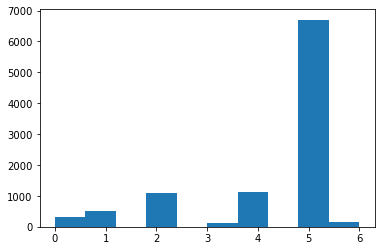

In [21]:
le = LabelEncoder()
labels = le.fit_transform(label_df)
plt.hist(labels)

In [22]:
skincancer_df.head()

,lesion_id,image_id,age,dx_type,sex,localization,dx
0,HAM_0000118,ISIC_0027419,80.0,histo,male,scalp,bkl
1,HAM_0000118,ISIC_0025030,80.0,histo,male,scalp,bkl
2,HAM_0002730,ISIC_0026769,80.0,histo,male,scalp,bkl
3,HAM_0002730,ISIC_0025661,80.0,histo,male,scalp,bkl
4,HAM_0001466,ISIC_0031633,75.0,histo,male,ear,bkl


In [23]:
le_skincancer_df = skincancer_df.copy()

In [24]:
le_skincancer_df['dxtype'] = dxtype_feat
le_skincancer_df['sex'] = sex_feat
le_skincancer_df['loc'] = loc_feat
le_skincancer_df['label'] = labels
le_skincancer_df.drop(columns=['localization', 'dx_type', 'dx'], inplace = True)
le_skincancer_df.head()

,lesion_id,image_id,age,sex,dxtype,loc,label
0,HAM_0000118,ISIC_0027419,80.0,1,3,3,2
1,HAM_0000118,ISIC_0025030,80.0,1,3,3,2
2,HAM_0002730,ISIC_0026769,80.0,1,3,3,2
3,HAM_0002730,ISIC_0025661,80.0,1,3,3,2
4,HAM_0001466,ISIC_0031633,75.0,1,3,3,2


## Bygg en egen dataloader-klass för bilder och csv

In [31]:
le_skincancer_df.iloc[0, 2:6]

age       80
sex        1
dxtype     3
loc        3
Name: 0, dtype: object

In [39]:
class SkinCancerHamCSV(Dataset):

    def __init__(self, csv_file, root_dir, transform = None):
        """
            csv_file (string): 
            Path to the csv file with annotations.
            
            root_dir (string): 
            Directory with all the images.
            transform (callable, optional): Optional transform to be applied
            on a sample.
        """
        self.skincancer_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.skincancer_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.skincancer_df.iloc[idx, 1])
        
        img_name = img_name + ".jpg"
        
        image = io.imread(img_name)
        
        # Read columns from csv:
        # labels:
        skincancer_label = self.skincancer_df.iloc[idx, 6:]
        skincancer_label_np = np.array([skincancer_label])
        
        # features:
        skincancer_metadata = self.skincancer_df.iloc[idx, 2:6]
        skincancer_metadata_np = np.array([skincancer_metadata])
        
        # Skapar en batch utan transforms:
        sample = {'image': image, \
                  'metadata': skincancer_metadata_np, \
                  'label': skincancer_label_np}

        # Skapar en batch med transforms:
        if self.transform:
            sample = {'image': self.transform(image), \
                      'metadata': skincancer_metadata_np, \
                      'label': skincancer_label_np}

        return sample

In [134]:
# Samma klass som ovan, men läser från en 
# Pandas-df istället från en csv:

class SkinCancerHamDF(Dataset):

    def __init__(self, dataframe, root_dir, transform = None):

        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.dataframe.iloc[idx, 1])
        
        img_name = img_name + ".jpg"
        
        # sklearn-image:
        # image = io.imread(img_name)
        
        # pillow:
        image = Image.open(img_name)
        
        # Read columns from csv:
        # labels:
        skincancer_label = self.dataframe.iloc[idx, 6:]
        skincancer_label_np = np.array([skincancer_label], dtype = int)
        
        # features:
        skincancer_metadata = self.dataframe.iloc[idx, 2:6]
        skincancer_metadata_np = np.array([skincancer_metadata], dtype = float)
        
        # Skapar en batch utan transforms:
        sample = {'image': image, \
                  'metadata': skincancer_metadata_np, \
                  'label': skincancer_label_np}

        # Skapar en batch med transforms:
        if self.transform:
            sample = {'image': self.transform(image), \
                      'metadata': skincancer_metadata_np, \
                      'label': skincancer_label_np}

        return sample

### Testa klassen...

In [175]:
# Definiera en batch-storlek:
batchsz = 2**4

# Definiera vilken augmentation som ska göras:
train_data_transform = transforms.Compose([transforms.Resize([224, 224]),\
                                           transforms.ToTensor()
                                           ])

val_test_data_transform = transforms.Compose(
    [
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]
)

In [176]:
ham10k_dataset = SkinCancerHamDF(dataframe = le_skincancer_df, \
                               root_dir = basePath, \
                               transform = train_data_transform)

In [177]:
next(iter(ham10k_dataset))

{'image': tensor([[[0.7333, 0.7451, 0.7529,  ..., 0.7647, 0.7647, 0.7647],
          [0.7373, 0.7490, 0.7569,  ..., 0.7608, 0.7647, 0.7686],
          [0.7412, 0.7529, 0.7569,  ..., 0.7608, 0.7686, 0.7686],
          ...,
          [0.6275, 0.6392, 0.6471,  ..., 0.7255, 0.7137, 0.7020],
          [0.6157, 0.6235, 0.6392,  ..., 0.7255, 0.7098, 0.6941],
          [0.6078, 0.6157, 0.6275,  ..., 0.7216, 0.7098, 0.6902]],
 
         [[0.5882, 0.6039, 0.6118,  ..., 0.6000, 0.6078, 0.6157],
          [0.5922, 0.6078, 0.6118,  ..., 0.6039, 0.6157, 0.6157],
          [0.5882, 0.5961, 0.6000,  ..., 0.6039, 0.6157, 0.6118],
          ...,
          [0.4902, 0.4980, 0.5059,  ..., 0.6000, 0.5882, 0.5725],
          [0.4863, 0.4902, 0.4902,  ..., 0.6039, 0.5843, 0.5686],
          [0.4745, 0.4745, 0.4745,  ..., 0.6118, 0.5922, 0.5686]],
 
         [[0.7529, 0.7647, 0.7765,  ..., 0.6549, 0.6588, 0.6667],
          [0.7569, 0.7686, 0.7765,  ..., 0.6549, 0.6588, 0.6627],
          [0.7529, 0.7569, 0.76

In [178]:
#ham10k_generator = DataLoader(ham10k_dataset, **params)

ham10k_generator = DataLoader(ham10k_dataset, \
                              batch_size = 2**4, \
                              pin_memory = True, \
                             )

In [64]:
# Parameters
params = {'batch_size': 2**4,
          'shuffle': True,
          'num_workers': 4}

In [179]:
next(iter(ham10k_generator))

{'image': tensor([[[[0.7333, 0.7451, 0.7529,  ..., 0.7647, 0.7647, 0.7647],
           [0.7373, 0.7490, 0.7569,  ..., 0.7608, 0.7647, 0.7686],
           [0.7412, 0.7529, 0.7569,  ..., 0.7608, 0.7686, 0.7686],
           ...,
           [0.6275, 0.6392, 0.6471,  ..., 0.7255, 0.7137, 0.7020],
           [0.6157, 0.6235, 0.6392,  ..., 0.7255, 0.7098, 0.6941],
           [0.6078, 0.6157, 0.6275,  ..., 0.7216, 0.7098, 0.6902]],
 
          [[0.5882, 0.6039, 0.6118,  ..., 0.6000, 0.6078, 0.6157],
           [0.5922, 0.6078, 0.6118,  ..., 0.6039, 0.6157, 0.6157],
           [0.5882, 0.5961, 0.6000,  ..., 0.6039, 0.6157, 0.6118],
           ...,
           [0.4902, 0.4980, 0.5059,  ..., 0.6000, 0.5882, 0.5725],
           [0.4863, 0.4902, 0.4902,  ..., 0.6039, 0.5843, 0.5686],
           [0.4745, 0.4745, 0.4745,  ..., 0.6118, 0.5922, 0.5686]],
 
          [[0.7529, 0.7647, 0.7765,  ..., 0.6549, 0.6588, 0.6667],
           [0.7569, 0.7686, 0.7765,  ..., 0.6549, 0.6588, 0.6627],
           [0.7

## Create code for moving to GPU, if available

In [76]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [77]:
device = get_default_device()

In [78]:
print(device)

cuda


### De båda nedanstående blocken används för att enkelt flytta till GPU: 

In [79]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [80]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

#### Flytta train_loader och test_loader till GPU:n

In [81]:
train_dl = DeviceDataLoader(ham10k_generator, device)
#valid_dl = DeviceDataLoader(valid_loader, device)
#test_dl = DeviceDataLoader(test_loader, device)

In [82]:
train_dl.device

device(type='cuda')

In [19]:
valid_dl.device

device(type='cuda')

In [20]:
test_dl.device

device(type='cuda')

## Bygg ett eget CNN-nät:

In [84]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 5, stride = 2)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 64, kernel_size = 5, stride = 2)
        self.fc1 = nn.Linear(in_features = 64*13*13, out_features = 100)
        self.fc2 = nn.Linear(in_features = 100, out_features = 7)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        # X = F.max_pool2d(X, kernel_size=2, stride=2)
        m = nn.MaxPool2d(kernel_size = 2, stride = 2)
        X = m(X)
        X = F.relu(self.conv2(X)) # 12  - 5 + 1 = 8px
        #
        # Kan man slå isär dessa steg? Japp!
        # X = self.conv2(X) # 12  - 5 + 1 = 8px
        # X = F.relu(X)
        #
        X = F.max_pool2d(X, kernel_size = 2, stride = 2) # 8/2 = 4px
        # print(X.shape) # kommer visa sig när vi tränar modellen nedan...
        X = X.view(-1, 64*13*13) # flatten
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        return F.log_softmax(X, dim = 1)

In [85]:
torch.manual_seed(17)
model = ConvolutionalNetwork()

In [86]:
trainableparameters = []
for param in model.parameters():
    # trainableparameters = param.numel()
    trainableparameters.append(param.numel())

print("Antalet träningsbara parametrar är =", np.sum(trainableparameters), "st.")


Antalet träningsbara parametrar är = 1109287 st.


### Hur blir tensor-storlekarna när de flödar genom ovanstående nät?

In [96]:
torch.tensor([1,2,3])

tensor([1, 2, 3])

In [97]:
test_dict = {'image': torch.tensor([1,2,3]), 'label': torch.tensor([1])}

In [113]:
test_dict['image'].shape

torch.Size([3])

In [143]:
for x in ham10k_generator:
    x = x['image']
    print("Ursprunglig storlek: ", x.shape)
    break

Ursprunglig storlek:  torch.Size([16, 3, 224, 298])


In [144]:
x = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 5, stride = 2)(x)
print("Efter Conv2d(1, 3, 5, 2): ", x.shape)

Efter Conv2d(1, 3, 5, 2):  torch.Size([16, 16, 110, 147])


In [145]:
x = nn.MaxPool2d(kernel_size = 2, stride = 2)(x)
print("Efter Pooling, kernel_size = 2, stride = 2 så blir storleken: ", x.shape)

Efter Pooling, kernel_size = 2, stride = 2 så blir storleken:  torch.Size([16, 16, 55, 73])


In [146]:
x = nn.Conv2d(in_channels = 16, out_channels = 64, kernel_size = 5, stride = 2)(x)
print(x.shape)

torch.Size([16, 64, 26, 35])


In [147]:
x = nn.MaxPool2d(kernel_size = 2, stride = 2)(x)
print("Efter Pooling, kernel_size = 2, stride = 2 så blir storleken: ", x.shape)

Efter Pooling, kernel_size = 2, stride = 2 så blir storleken:  torch.Size([16, 64, 13, 17])


In [151]:
x.view(-1, 64*13*17).shape

torch.Size([16, 14144])

### Flytta modellen till GPU, om en sådan finns:

In [152]:
# Flytta modellen till GPU:

to_device(model, device)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(16, 64, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=10816, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=7, bias=True)
)

In [153]:
# Verifiera att modellen är på rätt device:
# True => modellen finns på GPU.

next(model.parameters()).is_cuda

True

### 6. Define loss function & optimizer

In [156]:
# Definiera loss-function och vilken optimerare som ska användas:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

### Trainingloop:

In [159]:
len(ham10k_dataset)

10015

In [166]:
for X in ham10k_generator:
    print(X['label'])
    break

tensor([[[2]],

        [[2]],

        [[2]],

        [[2]],

        [[2]],

        [[2]],

        [[2]],

        [[2]],

        [[2]],

        [[2]],

        [[2]],

        [[2]],

        [[2]],

        [[2]],

        [[2]],

        [[2]]])


In [171]:
for inputs in ham10k_generator:
        images = inputs['image']
        labels = inputs['label']
        
        print(images.shape)
        print(labels.shape)
        #predictions = model.forward(images)
        break

torch.Size([16, 3, 224, 298])
torch.Size([16, 1, 1])


In [167]:
import time
start_training_time = time.time()

epochs = 10

no_training_images = len(ham10k_dataset)

train_accuracy = []
train_losses = []

for epoch in range(epochs):
    start_epoch_time = time.time()
    correct_pred_per_epoch = 0
    
    for inputs in ham10k_generator:
        images = inputs['image']
        labels = inputs['label']
        
        predictions = model.forward(images)
        train_loss = criterion(predictions, labels)
        
        # Beräkna statistik från träningen på träningsmängden:
        predicted = torch.max(predictions.data, 1)[1]
        is_correct = (predicted == labels).sum()
        correct_pred_per_epoch += is_correct
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    
    # För träningsmängden:
    # Lagra accuracy och loss per epok för t.ex. plottning:
    accuracy_per_epoch = correct_pred_per_epoch.item() / no_training_images
    train_accuracy.append(accuracy_per_epoch)
    train_losses.append(train_loss)
    
    end_epoch_time = time.time()
    epoch_time = end_epoch_time - start_epoch_time
    # epoch startar på 0, därav "+1" nedan:
    print(f"Epok {epoch+1:02}, {epoch_time:2.2f} sek.: Träning: accuracy = {accuracy_per_epoch:4.4f} och loss är = {train_loss:4.4f}")
    
end_training_time = time.time()

delta = end_training_time - start_training_time

print(f'\nTraining took {delta/60:.2f} minutes.')    

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same

In [ ]:
# Gammal loop för backup...


import time
start_training_time = time.time()

epochs = 10

no_training_images = len(ham10k_dataset)

train_accuracy = []
train_losses = []

for epoch in range(epochs):
    start_epoch_time = time.time()
    train_correct_pred_per_epoch = 0
    
    for inputs in ham10k_generator:
        images = input['image']
        labels = input['labels']
        predictions = model.forward(images)
        train_loss = criterion(predictions, labels)
        
        # Beräkna statistik från träningen på träningsmängden:
        train_predicted = torch.max(y_train_pred.data, 1)[1]
        train_is_correct = (train_predicted == y_train).sum()
        train_correct_pred_per_epoch += train_is_correct
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    
    # För träningsmängden:
    # Lagra accuracy och loss per epok för t.ex. plottning:
    train_epoch_accuracy = train_correct_pred_per_epoch.item() / no_training_images
    train_accuracy.append(train_epoch_accuracy)
    train_losses.append(train_loss)
    
    end_epoch_time = time.time()
    epoch_time = end_epoch_time - start_epoch_time
    # epoch startar på 0, därav "+1" nedan:
    print(f"Epok {epoch+1:02}, {epoch_time:2.2f} sek.: Träning: accuracy = {train_epoch_accuracy:4.4f} och loss är = {train_loss:4.4f}")
    
end_training_time = time.time()

delta = end_training_time - start_training_time

print(f'\nTraining took {delta/60:.2f} minutes.')    

In [ ]:
# Valideringsmängden:
model.eval()

valid_correct_pred_per_epoch = 0
valid_accuracy = []
valid_losses = []

no_valid_images = len(valid_loader.dataset) # = 998
with torch.no_grad():
    # Antal iterationer = 998 / 16 = 63 st.
    for X_valid, y_valid in valid_dl:

        y_valid_pred = model.forward(X_valid)
        
        valid_predicted = torch.max(y_valid_pred.data, 1)[1]
        valid_is_correct = (valid_predicted == y_valid).sum()
        valid_correct_pred_per_epoch += valid_is_correct
        
        valid_loss = criterion(y_valid_pred, y_valid)
        valid_losses.append(valid_loss.item())
            
        valid_epoch_accuracy = valid_correct_pred_per_epoch.item() / no_valid_images
        valid_accuracy.append(valid_epoch_accuracy)
        
# epoch startar på 0, därav "+1" nedan:
print(f"Validering: accuracy = {valid_epoch_accuracy:4.4f} och loss är = {valid_loss:4.4f}")

In [ ]:
# Plotta accuracy och loss:

max_loss = np.max(train_losses).item()
max_accuracy = np.max(train_accuracy).item()
y_max = 1.1*max(max_loss, max_accuracy)

plt.plot(range(epochs), train_accuracy)
plt.plot(range(epochs), train_losses)
plt.title("Accuracy and loss per epoch on the train set")
plt.legend(['Accuracy', 'Loss'], loc='lower left')
plt.yticks(np.arange(0, y_max, step = 0.2))
plt.ylim(0, y_max)
plt.show()

In [ ]:
max_loss = np.max(valid_losses).item()
max_accuracy = np.max(valid_accuracy).item()
y_max = 1.1*max(max_loss, max_accuracy)

plt.plot(range(len(valid_losses)), valid_accuracy)
plt.plot(range(len(valid_losses)), valid_losses)
plt.title("Accuracy and loss on the validation set")
plt.legend(['Accuracy', 'Loss'], loc='upper left')
plt.yticks(np.arange(0, y_max, step = 0.2))
plt.ylim(0, y_max)
plt.show()

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode = was_training)
                    return
        model.train(mode = was_training)

### Elaborate training loop:

In [ ]:
import time
start_time = time.time()

epochs = 16

no_training_images = len(dataset_trainloader.dataset) # 7007

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for epoch in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for currentbatch, (X_train, y_train) in enumerate(train_dl):
        currentbatch += 1
        
        # Apply the model
        y_pred_train = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred_train, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred_train.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if currentbatch % 100 == 0:
            print(f'epoch: {epoch:2}  batch: {currentbatch:4} [{batchsz*currentbatch:4}/{no_training_images}]\
            loss: {loss.item():5.4f}\
            accuracy: {trn_corr.item()*100/(batchsz*currentbatch):5.1f} %')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)

print(f'\nTraining took: {time.time() - start_time:.0f} seconds.') # print the time elapsed    

### 8. Evaluate the model on the test-set

In [ ]:
len(test_loader.dataset)

In [ ]:
model.eval()

no_test_images = len(test_loader.dataset)

with torch.no_grad():
    correct = 0
    # Antal iterationer = 2010 / 16 = 123 st.
    for X_test, y_test in test_dl:
        y_pred_test = model.forward(X_test)
        predicted = torch.max(input = y_pred_test, dim = 1)[1]
        correct += (predicted == y_test).sum()
        
print(f'Test accuracy: {correct.item()}/{no_test_images} = {correct.item()*100/(no_test_images):5.2f} %')